## Analysis of spread of COVID in Bihar

In [393]:
# import the necessary libraries
import numpy as np 
import pandas as pd 
import os

# Visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import json
from pywaffle import Waffle
import datetime
from datetime import datetime, timedelta
py.init_notebook_mode(connected=True)
import folium 
from folium import plugins
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = 8, 5
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet
#from fbprophet.plot import plot_plotly

import warnings
warnings.filterwarnings('ignore')


In [299]:
path_info = os.getcwd()

dateval = '27JULY2020'

age_details = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'AgeGroupDetails.csv')
india_covid_19 = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'covid_19_india.csv')
hospital_beds = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'HospitalBedsIndia.csv')
population = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'population_india_census2011.csv')
individual_details = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'IndividualDetails.csv')
ICMR_labs = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ '/ICMRTestingLabs.csv')
state_testing = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ '/StatewiseTestingDetails.csv')




district_data = pd.read_csv("https://api.covid19india.org/csv/latest/districts.csv")
State_wise = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
State_daily = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise_daily.csv")
State_test = pd.read_csv("https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv")
MH_data = open(path_info + '/IndiaStateTopojson/Maharashtra.topojson')

india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

In [300]:
State_wise.head()


,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,Migrated_Other,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes
0,Total,1532135,988770,34224,508718,28/07/2020 23:59:28,423,TT,49632,35671,770,NaN
1,Maharashtra,391440,232277,14165,144694,28/07/2020 20:50:34,304,MH,7717,10333,282,304 cases are marked as non-covid deaths in MH...
2,Tamil Nadu,227688,166956,3659,57073,28/07/2020 19:30:28,0,TN,6972,4707,88,[July 22]: 444 backdated deceased entries adde...
3,Delhi,132275,117507,3881,10887,28/07/2020 18:18:30,0,DL,1056,1135,28,[July 14]: Value for the total tests conducted...
4,Karnataka,107001,40504,2057,64431,28/07/2020 19:30:30,9,KA,5536,2819,102,9 cases are classified as non-covid related de...


Text(0.85,0.65,'<@Author Rituraj Singh>')

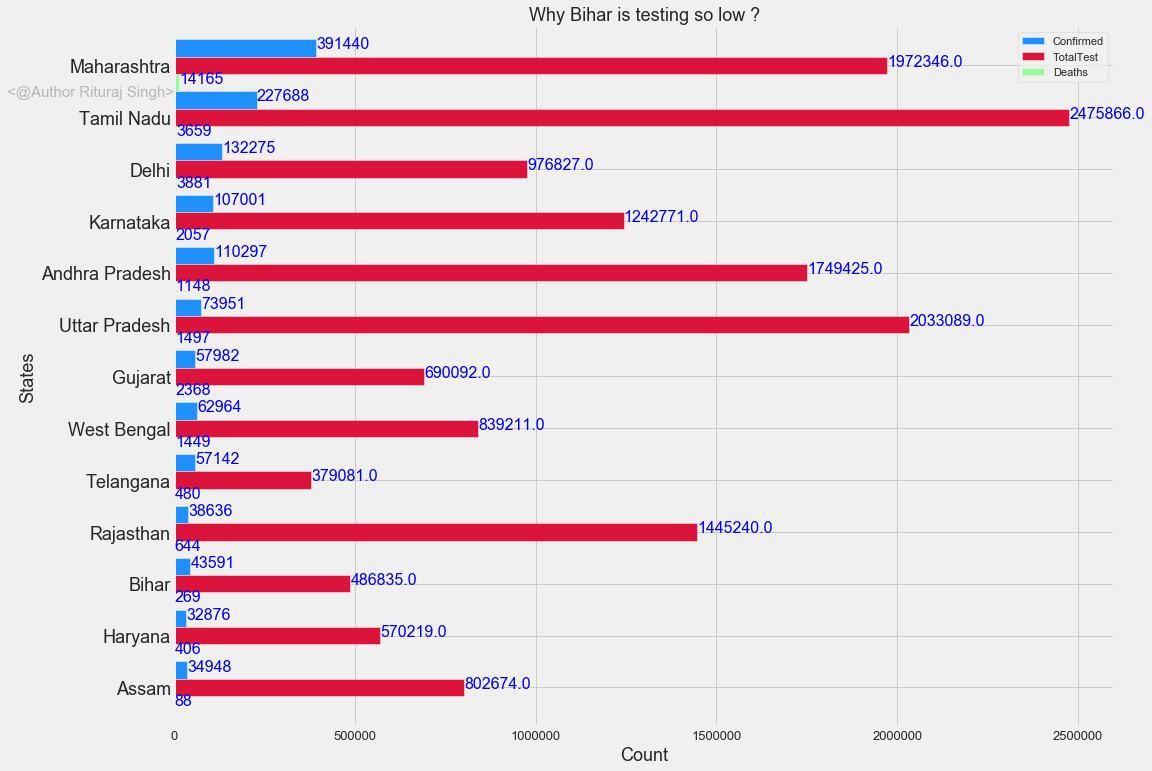

In [301]:
new_dataTested = State_test[['Updated On','State','Total Tested']]
groupedData = new_dataTested.groupby('State')
TestedState = groupedData['Total Tested'].agg([np.max]).reset_index()
new_data = State_wise [['State', 'Confirmed','Deaths', 'Active']]
merged_Frame = new_data.merge(TestedState, on="State", how = 'inner')
merged_Frame.sort_values(by='Confirmed', ascending=False)
merged_Frame.rename(columns={"amax": "TotalTest"}, inplace=True)
TopTen = merged_Frame.iloc[0:13]


ax = TopTen[['Confirmed', 'TotalTest','Deaths']].plot(kind='barh',width = 1,
              figsize=(15,12), color=['dodgerblue', 'Crimson','palegreen'], fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Why Bihar is testing so low ?",fontsize=18)
ax.set_xlabel("Count", fontsize=18)
ax.set_ylabel("States", fontsize=18)
#ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000, 120000, 140000])
ax.set_yticklabels(TopTen['State'],  fontsize=18)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+700, i.get_y()+.18, \
            str(round((i.get_width()), 2)), fontsize=16, color='blue')

centreCircle = plt.Circle((0,0),12.15,color="red",fill=False)
ax.add_patch(centreCircle)

# invert for largest on top 
ax.invert_yaxis()
ax.text(0.85, 0.65, '<@Author Rituraj Singh>',
         fontsize=15, color='gray',
         ha='right', va='bottom', alpha=0.5)

#plt.savefig(path_info + '/Data/' + '04June2020/' +"covidTest.png", bbox_inches='tight', dpi=600)

In [302]:
merged_Frame.rename(columns={"amax": "TotalTest"}, inplace=True)

In [303]:
merged_Frame['TestPositiveRate'] = merged_Frame['TotalTest']/merged_Frame['Confirmed']

In [304]:
merged_Frame.sort_values(by='TestPositiveRate', ascending=False)

,State,Confirmed,Deaths,Active,TotalTest,TestPositiveRate
34,Andaman and Nicobar Islands,363,1,165,22548.0,62.115702
25,Himachal Pradesh,2330,13,1068,137251.0,58.906009
33,Mizoram,384,0,186,20442.0,53.234375
28,Arunachal Pradesh,1330,3,710,68034.0,51.153383
31,Meghalaya,779,5,580,34687.0,44.527599
30,Dadra and Nagar Haveli and Daman and Diu,1030,2,369,41143.0,39.944660
32,Sikkim,592,1,392,22993.0,38.839527
17,Punjab,14378,336,4290,550267.0,38.271456
9,Rajasthan,38636,644,10675,1445240.0,37.406564
19,Chhattisgarh,8286,46,2801,297481.0,35.901641


In [305]:
india_covid_19.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [306]:
statewise_cases = pd.DataFrame(india_covid_19.groupby(['State/UnionTerritory'])['Confirmed', 'Deaths', 'Cured'].max().reset_index())
statewise_cases["Country"] = "India" 
fig = px.treemap(statewise_cases, path=['Country','State/UnionTerritory'], values='Confirmed',color='Confirmed', hover_data=['State/UnionTerritory'])
fig.update_layout(title_text = 'Active Covid-19 cases in India')
fig.show()

In [376]:
Bihar_covid_Test = State_test[State_test['State']== 'Bihar'].reset_index()

In [377]:
Bihar_covid_Test.head()

,index,Updated On,State,Total Tested,Tag (Total Tested),Positive,Negative,Unconfirmed,Cumulative People In Quarantine,Total People Currently in Quarantine,...,Corona Enquiry Calls,Num Calls State Helpline,Source1,Source2,Source3,Test positivity rate,Tests per thousand,Tests per million,Tests per positive case,Population NCP 2019 Projection
0,387,05/04/2020,Bihar,3037.0,Tested,32.0,2299,706.0,NaN,NaN,...,NaN,NaN,https://twitter.com/sanjayjavin/status/1246667...,NaN,NaN,1.05%,0.03,25.0,95,119520000.0
1,388,08/04/2020,Bihar,4596.0,Tested,38.0,NaN,465.0,NaN,NaN,...,NaN,NaN,https://twitter.com/sanjayjavin/status/1247762...,NaN,NaN,0.83%,0.04,38.0,121,119520000.0
2,389,09/04/2020,Bihar,4991.0,Tested,43.0,NaN,394.0,NaN,NaN,...,NaN,NaN,https://twitter.com/BiharHealthDept/status/124...,NaN,NaN,0.86%,0.04,42.0,116,119520000.0
3,390,10/04/2020,Bihar,5457.0,Tested,60.0,NaN,673.0,NaN,NaN,...,NaN,NaN,https://twitter.com/BiharHealthDept/status/124...,NaN,NaN,1.10%,0.05,46.0,91,119520000.0
4,391,11/04/2020,Bihar,6250.0,Tested,61.0,NaN,NaN,NaN,NaN,...,NaN,51075.0,https://twitter.com/BiharHealthDept/status/124...,https://twitter.com/BiharHealthDept/status/124...,NaN,0.98%,0.05,52.0,102,119520000.0


In [380]:
Bihar_covid_TestData =  Bihar_covid_Test[['Updated On', 'Total Tested','Positive','Test positivity rate', 'Tests per million']]
Bihar_covid_TestData.rename(columns={'Updated On':'UpdatedDate', 'Total Tested' : 'Tested','Test positivity rate' : 'TPV', 'Tests per million' : 'TPM' }, inplace = True)
Bihar_covid_TestData.reset_index(drop=True, inplace = True)
Bihar_covid_TestData.dropna(subset=['Tested'], inplace=True)
Bihar_covid_TestData['UpdatedDate'] = pd.to_datetime(Bihar_covid_TestData['UpdatedDate'],format = "%d/%m/%Y")
#Bihar_covid_TestData['UpdatedDate'] = pd.to_datetime(Bihar_covid_TestData['UpdatedDate'],infer_datetime_format=True)


In [385]:
fig= make_subplots(
    rows=2, cols=2,
    vertical_spacing = 0.2,
    subplot_titles=("Test per Day","Number of +ve per Day","Test Per Million", "Test Positive Rate", 'Positive Cases'))


fig.add_trace(go.Bar(x=Bihar_covid_TestData['UpdatedDate'], y=np.diff(Bihar_covid_TestData.Tested),
                       marker_color='indianred'),
              row = 1, col = 1)

fig.add_trace(go.Bar(x=Bihar_covid_TestData['UpdatedDate'], y=np.diff(Bihar_covid_TestData.Positive),
                    marker_color='indianred'),
              row = 1, col = 2)

fig.add_trace(go.Bar(x=Bihar_covid_TestData['UpdatedDate'], y=Bihar_covid_TestData.TPM,
                    marker_color='indianred'),
              row = 2, col = 1)

fig.add_trace(go.Bar(x=Bihar_covid_TestData['UpdatedDate'], y=Bihar_covid_TestData.TPV,
                      marker_color='indianred'),
              row = 2, col = 2)



fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False, title_text="Trend of Coronavirus cases in Bihar")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

In [312]:
Bihar_covid_status = district_data[district_data['State']== 'Bihar']
Bihar_covid_status = Bihar_covid_status.drop_duplicates(["District"], keep = 'last', inplace = False)
Bihar_covid_status['Active_Cases'] = Bihar_covid_status['Confirmed'] - (Bihar_covid_status['Recovered'] + Bihar_covid_status['Deceased'])

In [313]:
Bihar_data = open(path_info + '/IndiaStateTopojson/Bihar.geojson', )
Bihar_geo_data = json.load(Bihar_data) 
fig = px.choropleth(Bihar_covid_status,geojson = Bihar_geo_data, color = "Active_Cases",
                    locations = "District", featureidkey = "properties.Dist_Name",
                    color_continuous_scale="Viridis",
                    title = "Bihar  District level Covid-19 Active Cases"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text = 'Active Covid-19 cases in Bihar')
fig.show()

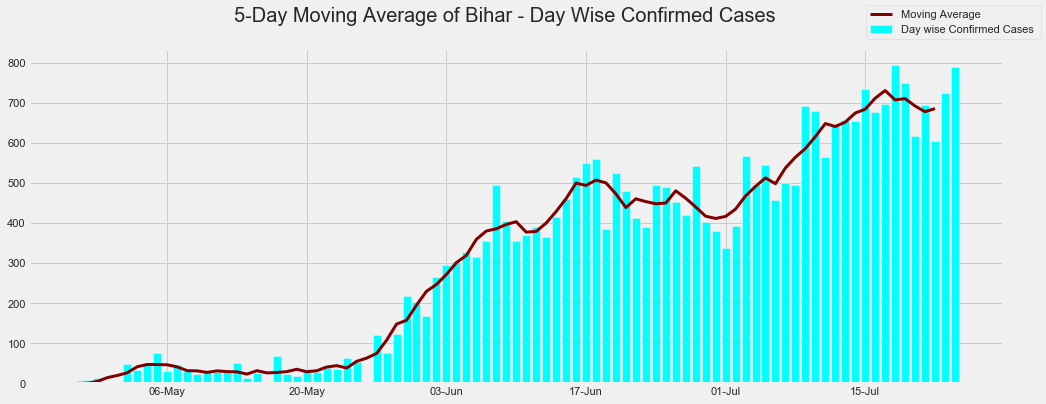

In [391]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
latest = india_covid_19[india_covid_19['Date'] > '25-04-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
statess =list(state_cases['State/UnionTerritory'][0:15])
states=[]
states.append(statess[11])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calc_movingaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

fig = plt.figure(figsize= (15,6))
plt.suptitle('5-Day Moving Average of Bihar - Day Wise Confirmed Cases',fontsize = 20,y=1.0)
k=0
for i in range(1,2):
    ax = fig.add_subplot(1,1,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ', color='#00FFFF') 
    moving_aves = calc_movingaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='#800000',label = 'Moving Average',linewidth =3)  
    #plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    k=k+1
plt.tight_layout(pad=3.0)

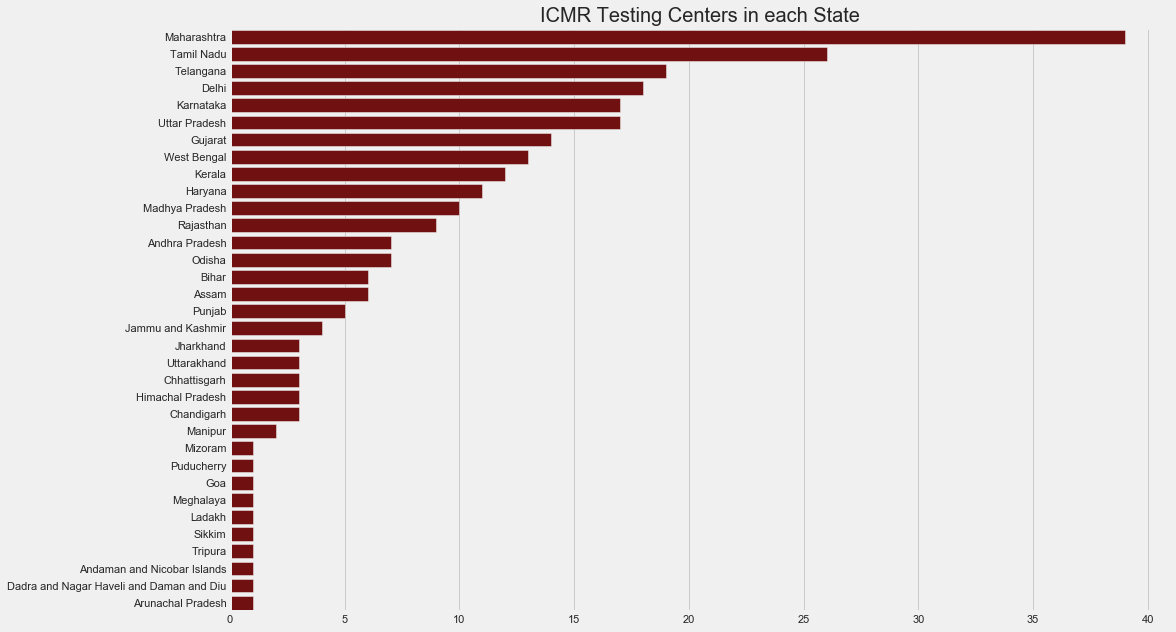

In [316]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#800000');

In [386]:
district_data['Tested'] = district_data['Tested'].fillna(0)
district_data.dtypes
district_data['Date'] = pd.to_datetime(district_data['Date'],infer_datetime_format=True)

In [387]:
Bihar_covid_status = district_data[district_data['State']== 'Bihar']
Bihar_covid_status['Date'] = pd.to_datetime(Bihar_covid_status['Date'],format = "%d/%m/%y")
Bihar_covid_summarised = Bihar_covid_status.groupby(['Date']).sum().reset_index()
Bihar_covid_summarised['Active_Cases'] = Bihar_covid_summarised['Confirmed'] - (Bihar_covid_summarised['Recovered'] + Bihar_covid_summarised['Deceased'])



fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Confirmed","Active_Cases", "Recovered","Death"))

fig.add_trace(go.Scatter(x=Bihar_covid_summarised['Date'], y=Bihar_covid_summarised['Confirmed'],
                    marker=dict(color=Bihar_covid_summarised['Confirmed'], coloraxis="coloraxis")),
              row = 1, col = 1)

fig.add_trace(go.Scatter(x=Bihar_covid_summarised['Date'], y=Bihar_covid_summarised['Active_Cases'],
                    marker=dict(color=Bihar_covid_summarised['Active_Cases'], coloraxis="coloraxis")),
              row = 1, col = 2)

fig.add_trace(go.Scatter(x=Bihar_covid_summarised['Date'], y=Bihar_covid_summarised['Recovered'],
                    marker=dict(color=Bihar_covid_summarised['Recovered'], coloraxis="coloraxis")),
              row = 2, col = 1)

fig.add_trace(go.Scatter(x=Bihar_covid_summarised['Date'], y=Bihar_covid_summarised['Deceased'],
                    marker=dict(color=Bihar_covid_summarised['Deceased'], coloraxis="coloraxis")),
              row = 2, col = 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Trend of Coronavirus cases in Bihar")

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

In [319]:
Bihar_covid_summarised.head()

,Date,Confirmed,Recovered,Deceased,Other,Tested,Active_Cases
0,2020-04-26,277,56,2,0,0.0,219
1,2020-04-27,346,56,2,0,0.0,288
2,2020-04-28,366,64,2,0,0.0,300
3,2020-04-29,403,64,2,0,0.0,337
4,2020-04-30,425,84,2,0,0.0,339


In [320]:
Bihar_covid_trends = Bihar_covid_status.drop_duplicates(["District"], keep = 'last', inplace = False)
Bihar_covid_trends = Bihar_covid_trends[["District","Confirmed","Recovered","Deceased"]]
Bihar_covid_trends['Active_Cases'] = Bihar_covid_trends['Confirmed'] - (Bihar_covid_trends['Recovered'] + Bihar_covid_trends['Deceased'])
Bihar_covid_trends['Mortality Rate Per 100'] = np.round((Bihar_covid_trends['Deceased']/Bihar_covid_trends['Confirmed'])*100,2)
Bihar_covid_trends = Bihar_covid_trends.replace(np.nan,0)
Bihar_covid_trends = Bihar_covid_trends.set_index('District')
Bihar_covid_trends.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Oranges',subset=["Active_Cases"])\
                        .background_gradient(cmap='Reds',subset=["Deceased"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='YlOrBr',subset=['Mortality Rate Per 100'])

,Confirmed,Recovered,Deceased,Active_Cases,Mortality Rate Per 100
District,,,,,
Patna,7481,4403,41,3037,0.55
Bhagalpur,2335,1717,26,592,1.11
Muzaffarpur,1943,1400,11,532,0.57
Gaya,1819,1002,17,800,0.93
Nalanda,1745,1087,15,643,0.86
Rohtas,1695,914,13,768,0.77
Begusarai,1497,1147,10,340,0.67
Siwan,1341,1101,7,233,0.52
Saran,1326,769,9,548,0.68


In [321]:
most_effected_Bihar_districts = Bihar_covid_status
most_effected_Bihar_districts['Active_Cases'] = most_effected_Bihar_districts['Confirmed'] - (most_effected_Bihar_districts['Recovered'] + most_effected_Bihar_districts['Deceased'])
most_effected_Bihar_districts = most_effected_Bihar_districts.groupby('District').sum().sort_values('Confirmed',ascending = False)
top5_most_effected_Bihar_districts = most_effected_Bihar_districts.head(5)
top5_most_effected_Bihar_districts['District'] = top5_most_effected_Bihar_districts.index
top_districts = top5_most_effected_Bihar_districts['District'].tolist()
## Check if the states name is present in "top 10 effected states" then include in the dataset
top5_most_effected_Bihar_districts_filtered = Bihar_covid_status[Bihar_covid_status['District'].isin(top_districts)]
top5_most_effected_Bihar_districts_filtered = top5_most_effected_Bihar_districts_filtered.drop_duplicates(["District"], keep = 'last', inplace = False)

In [322]:
confirmed_case_data = top5_most_effected_Bihar_districts_filtered.sort_values('Confirmed', ascending=True)
active_case_data = top5_most_effected_Bihar_districts_filtered.sort_values('Active_Cases', ascending=True)
recovered_case_data = top5_most_effected_Bihar_districts_filtered.sort_values('Recovered', ascending=True)
death_case_data = top5_most_effected_Bihar_districts_filtered.sort_values('Deceased', ascending=True)

fig = make_subplots(rows=4, cols=1, shared_yaxes=True, 
                    subplot_titles=("Top 5 District Confirmed Cases of Covid-19 in Bihar",
                                    "Top 5 District Active Cases of Covid-19 in Bihar",
                                    "Top 5 District Recovered Cases of Covid-19 in Bihar", 
                                    "Top 5 District Death Cases of Covid-19 in Bihar"))

fig.add_trace(go.Bar(x=confirmed_case_data['Confirmed'],
                        y=confirmed_case_data['District'],
                        name='Confirmed cases',
                        orientation = 'h',
                    ),
              1, 1)

fig.add_trace(go.Bar(x=active_case_data['Active_Cases'],
                        y=active_case_data['District'],
                        name='Active cases',
                        orientation = 'h',
                    ),
              2, 1)

fig.add_trace(go.Bar(x=recovered_case_data['Recovered'],
                     y=recovered_case_data['District'],
                    name='Recovered cases',
                    orientation = 'h'),
              3, 1)
fig.add_trace(go.Bar(x=death_case_data['Deceased'],
                     y=death_case_data['District'],
                    name='Deceased cases',
                    orientation = 'h'),
              4, 1)

fig.update_layout(height=800, width=600,coloraxis=dict(colorscale='viridis'))
fig.show()

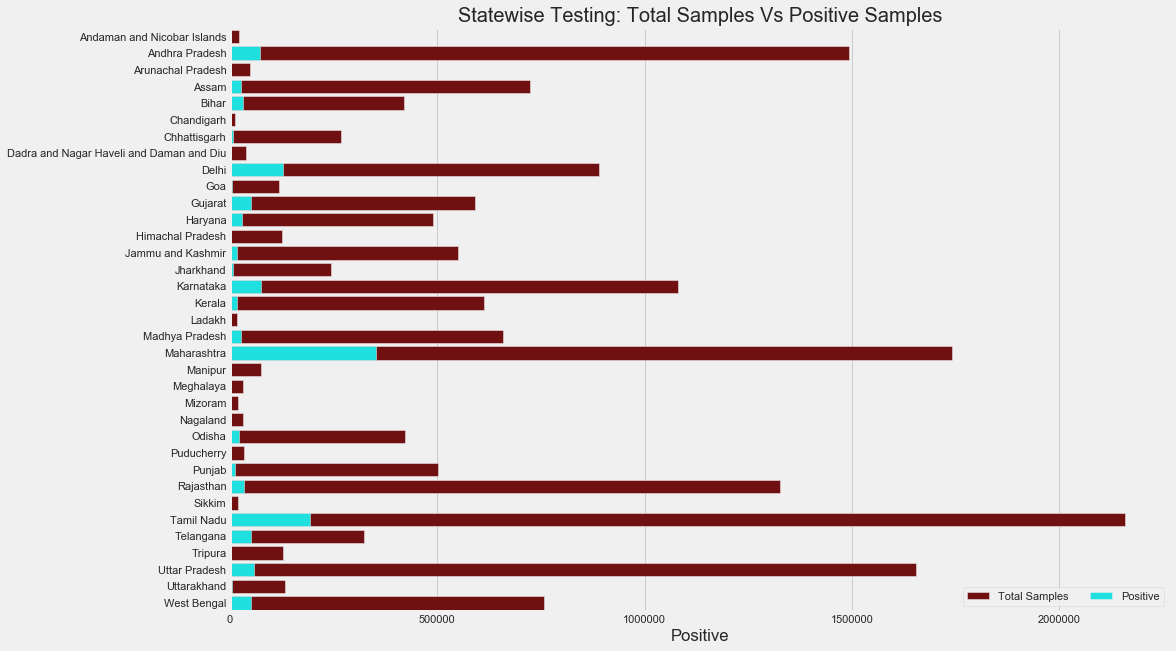

In [323]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples', 'Negative', 'Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = '#800000')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='#00FFFF')
plt.title('Statewise Testing: Total Samples Vs Positive Samples',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

In [324]:
# data preparation
#med = pd.read_csv('../input/covid19-in-india/HospitalBedsIndia.csv')
#pop = pd.read_csv('../input/covid19-in-india/population_india_census2011.csv')

med = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'HospitalBedsIndia.csv')
pop = pd.read_csv(path_info+'/' + 'Data/' + dateval + '/'+ 'population_india_census2011.csv')

pop.rename(columns={'State / Union Territory': 'State/UnionTerritory'}, inplace=True)
#med.drop(columns=['Sno',"Unnamed: 12","Unnamed: 13"],axis=1, inplace=True)
med.drop([36], inplace=True)
med.fillna('0', inplace=True)
med['NumPrimaryHealthCenters_HMIS'] = med['NumPrimaryHealthCenters_HMIS'].str.replace(',', '').astype(int)
med['NumCommunityHealthCenters_HMIS'] = med['NumCommunityHealthCenters_HMIS'].replace(',', '').astype(int)
med['NumSubDistrictHospitals_HMIS'] = med['NumSubDistrictHospitals_HMIS'].replace(',', '').astype(int)
med['NumDistrictHospitals_HMIS'] = med['NumDistrictHospitals_HMIS'].replace(',', '').astype(int)
med['TotalPublicHealthFacilities_HMIS'] = med['TotalPublicHealthFacilities_HMIS'].replace(',', '').astype(int)
med['NumPublicBeds_HMIS'] = med['NumPublicBeds_HMIS'].replace(',', '').astype(int)
med['TotalBeds'] = med[['NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']].sum(axis=1)

med.rename(columns={'State/UT': 'State/UnionTerritory'}, inplace=True)
med_pop = med.merge(pop[['State/UnionTerritory', 'Population']], on='State/UnionTerritory')

med_pop['Num Beds Per 1000 person'] = np.round(1000*med_pop["TotalBeds"]/med_pop["Population"],2)

In [325]:
fig1 = go.Figure(data=[go.Bar(
            x=med_pop['State/UnionTerritory'], 
            y=med_pop.NumPrimaryHealthCenters_HMIS,
            name='Primary Health Centers',
            marker_color='#0000FF'),
            
            go.Bar(
            x=med_pop['State/UnionTerritory'], 
            y=med_pop.NumCommunityHealthCenters_HMIS,
            name='Community HealthCenters',
            marker_color='#8B0000'),
            
            go.Bar(
            x=med_pop['State/UnionTerritory'], 
            y=med_pop.NumDistrictHospitals_HMIS,
            name='District Hospitals',
            marker_color='#228B22'),

            go.Bar(
            x=med_pop['State/UnionTerritory'], 
            y=med_pop.NumSubDistrictHospitals_HMIS,
            name='Sub-District Hospitals',
            marker_color='#FFD700')])


# Change the bar mode
fig1.update_layout(barmode='stack', template="ggplot2",width=1000, height=700, title_text = '<b>Total Public Health Facilities</b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig1.show()

In [326]:
med.head()

,Sno,State/UnionTerritory,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18,TotalBeds
0,1,Andaman & Nicobar Islands,27,4,0,3,34,1246,27,575,3,500,2321
1,2,Andhra Pradesh,1417,198,31,20,1666,60799,193,6480,65,16658,83937
2,3,Arunachal Pradesh,122,62,0,15,199,2320,208,2136,10,268,4724
3,4,Assam,1007,166,14,33,1220,19115,1176,10944,50,6198,36257
4,5,Bihar,2007,63,33,43,2146,17796,930,6083,103,5936,29815


In [327]:
fig = px.bar(med_pop, 
             x='State/UnionTerritory', y="TotalBeds",  
             text='TotalBeds', 
             orientation='v')
fig.update_traces(marker_color='#FF1493', opacity=0.8, textposition='inside')

fig.update_layout(template="ggplot2",width=700, height=700, title_text = '<b>Total Hospital Beds</b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig.show()

fig1 = px.scatter(med_pop, 
             x='State/UnionTerritory', y="Num Beds Per 1000 person")
fig1.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  marker_color='#FF1493',
                  mode='lines+markers')

fig1.update_layout(template="plotly_white",width=700, height=700, title_text = '<b>Number of Hospital Beds Available For Every 1000 Person</b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig1.show()

In [328]:
india_covid_19.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


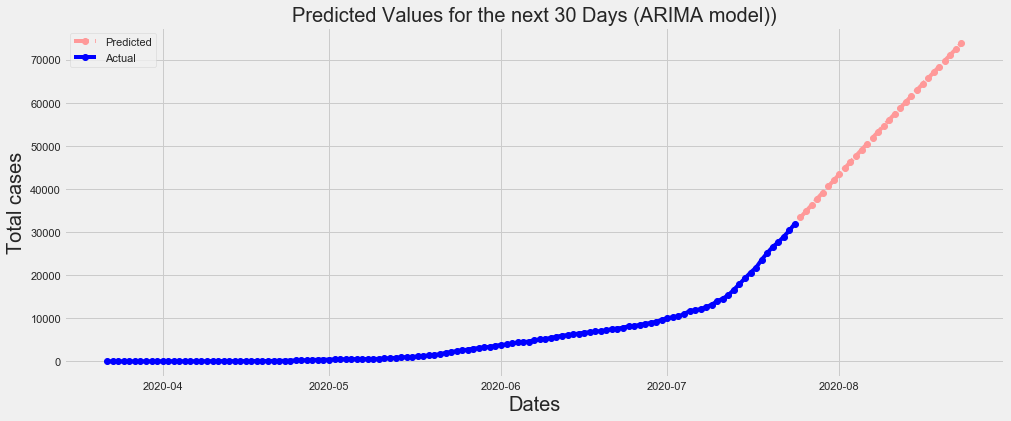

In [395]:
biharData = india_covid_19[india_covid_19['State/UnionTerritory'] =='Bihar']
biharData = biharData[['Date', 'Confirmed']]

biharData.columns = ['ds','y']



arima = ARIMA(biharData['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = biharData['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,6))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 30 Days (ARIMA model))" , fontsize = 20)


plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=biharData['y'],x=biharData['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [396]:
biharDataConfirmed = np.asanyarray(biharData.y)
growth_diff = []
for i in range(1,len(biharDataConfirmed)):
    growth_diff.append(biharDataConfirmed[i] / biharDataConfirmed[i-1])
    
growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.0858901561059302


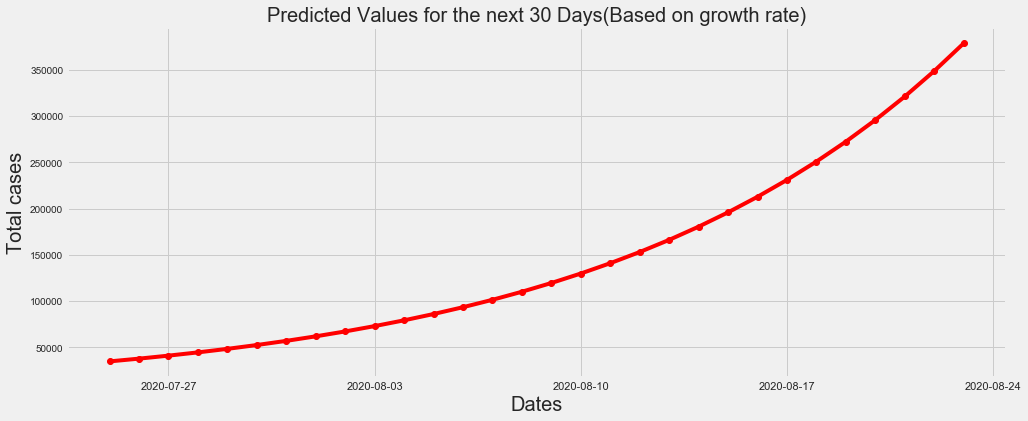

In [398]:
prediction_dates = []

#start_date = dates_india[len(dates_india) - 1]
start_date = biharData['ds'].max()
for i in range(30):
    date = start_date + timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = biharDataConfirmed[len(biharDataConfirmed) - 1]
predicted_cases = []

for i in range(30):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

ax = plt.figure(figsize= (15,6))
#plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 30 Days(Based on growth rate)" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = '#FF0000')
#plt.set_major_formatter(mdates.DateFormatter('%b %d %H:%M', tz=tz.gettz('Asia/Kolkata')))

In [ ]:
growth_diff